# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [6]:
print(f"Columns = {df_reviews.columns}")
df_reviews.head(2)

Columns = Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336


In [7]:
print(df_reviews.shape)
df_reviews.info()

(47331, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtype

In [8]:
print(f"Duplicates = {df_reviews.duplicated().sum()}")
df_reviews.isna().sum()

Duplicates = 0


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
df_reviews[df_reviews['votes'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [10]:
df_reviews[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [11]:
df_reviews = df_reviews.dropna()

In [12]:
print(df_reviews.shape)
df_reviews.isna().sum()

(47329, 17)


tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

<div span style=color:blue>
    Comments: The data was pre-loaded, I ran info, shape, head and describe, to see what the data looks like. The dataset has 17 columns, 47,331 rows, 2 columns with NA values and 0 duplicate rows. I checked all data types looked correct. The 2 columns with NA values are 'average_rating' and 'votes', and interestingly it is only 2 rows that have both of these values missing. So there is in total only 2 rows with Null values, it will not affect the dataset to simply remove them. After this, I moved on to the EDA.
</div>

## EDA

Let's check the number of movies and reviews over years.

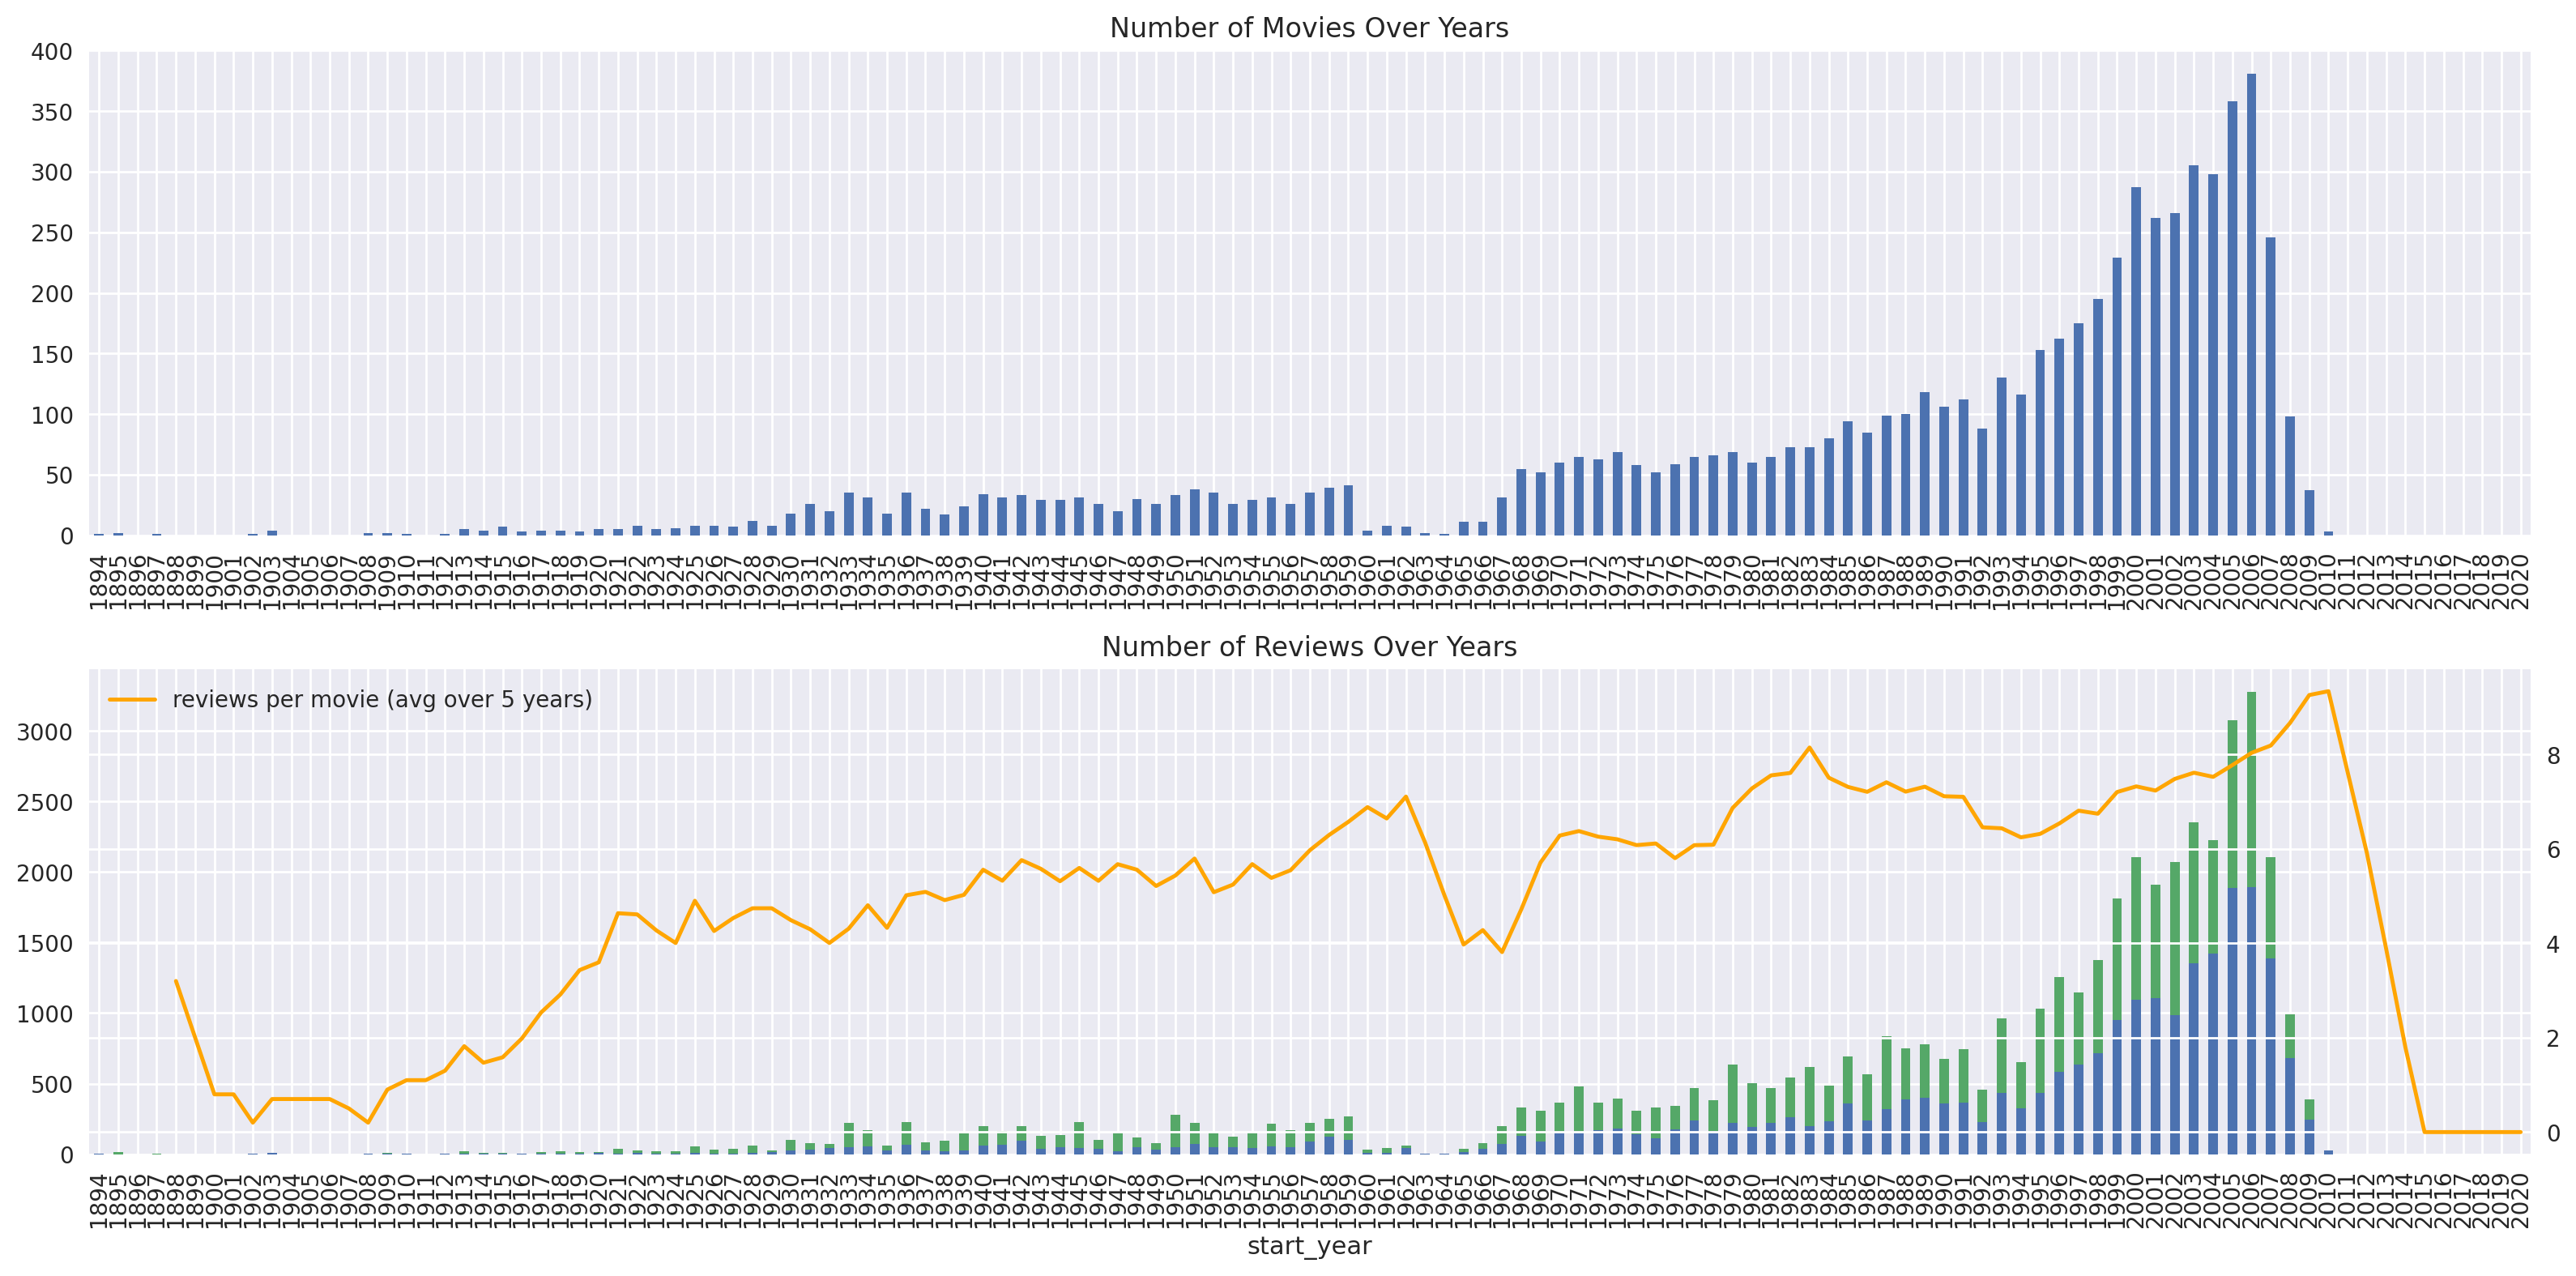

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

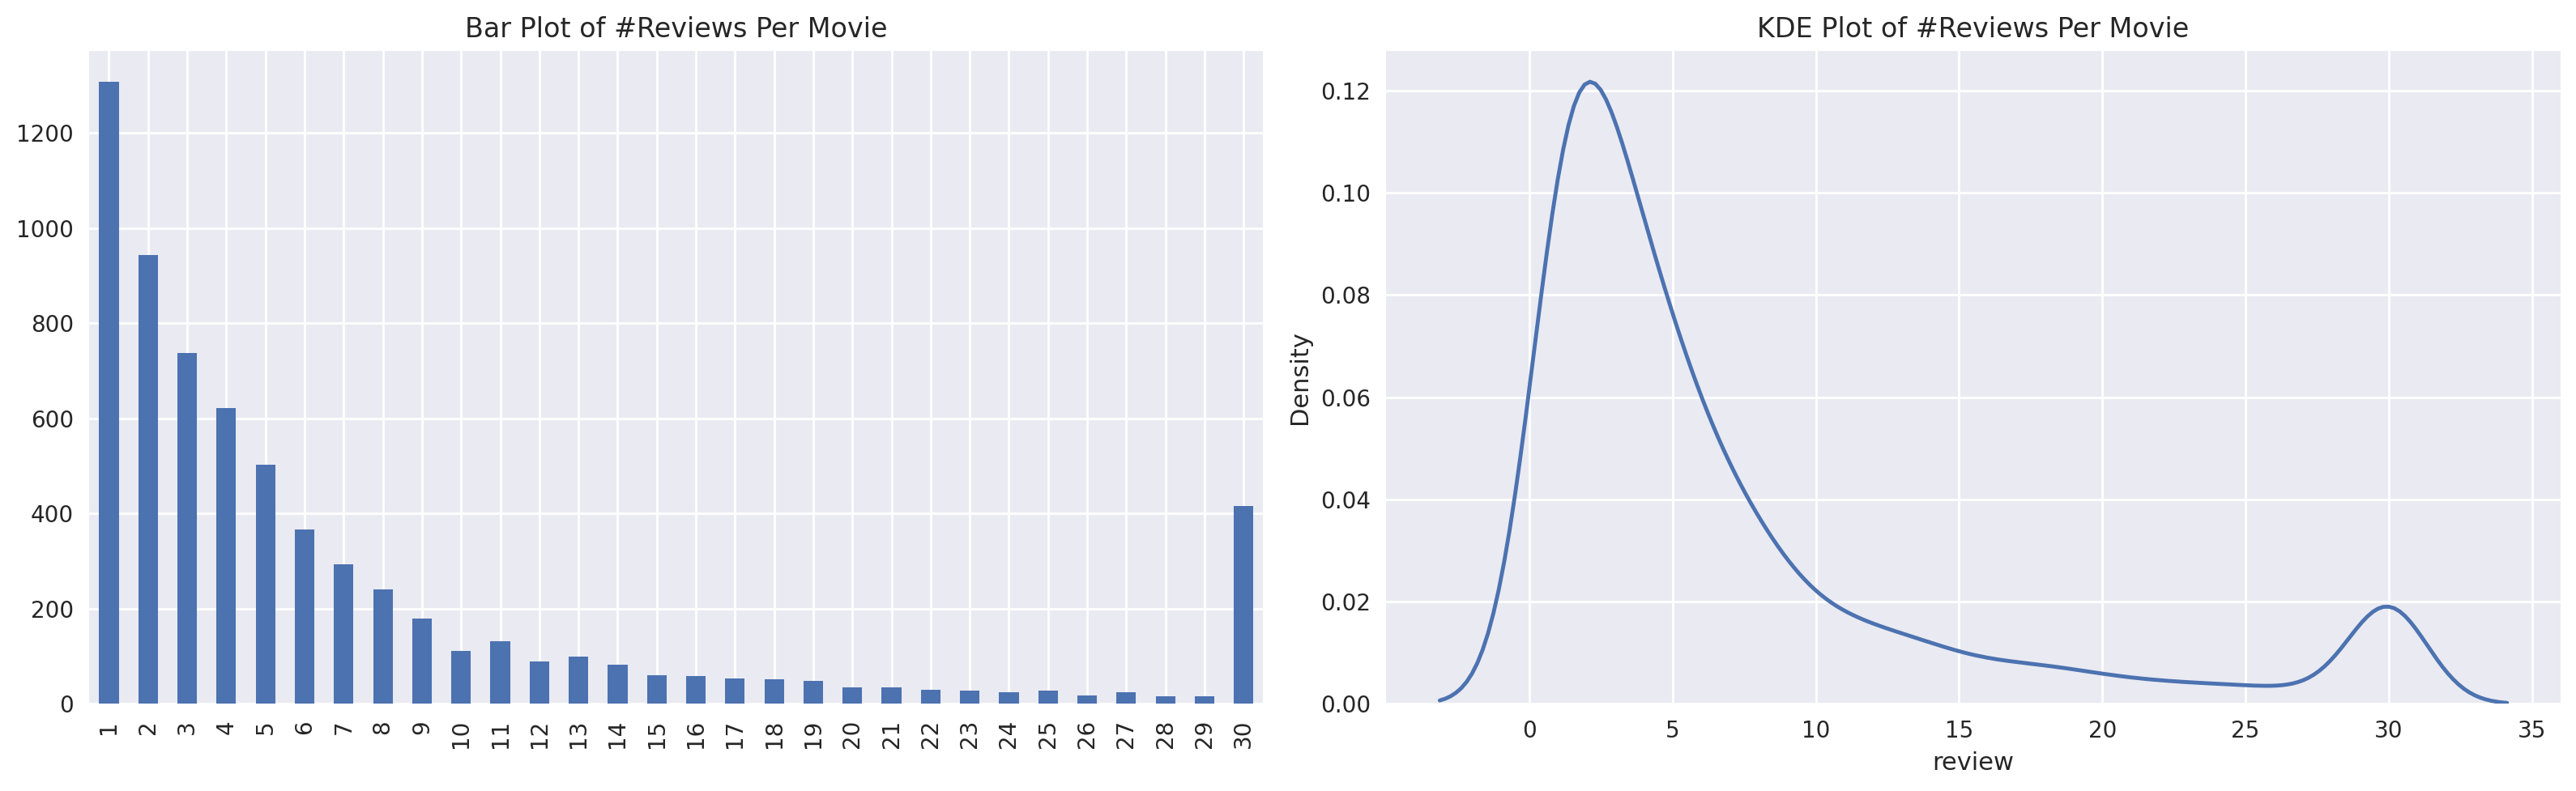

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

<span style=color:blue>  Comments: Looking at the value_counts on the target column 'pos' we see the class is actually quite balanced as there are about equal number of counts for 0 (neg) and 1 (pos). As such we don't need to worry about class imbalance. The bar plot and KDE plot show how the data is distributed and where it is mainly concentrated. For example, in terms of # of reviews per movie, we see that most of the movies have about 1 to 3 reviews. We also see a peak in moviews with 30 reviews. This type of distribution is great for data analysis and understanding the dataset.

In [15]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

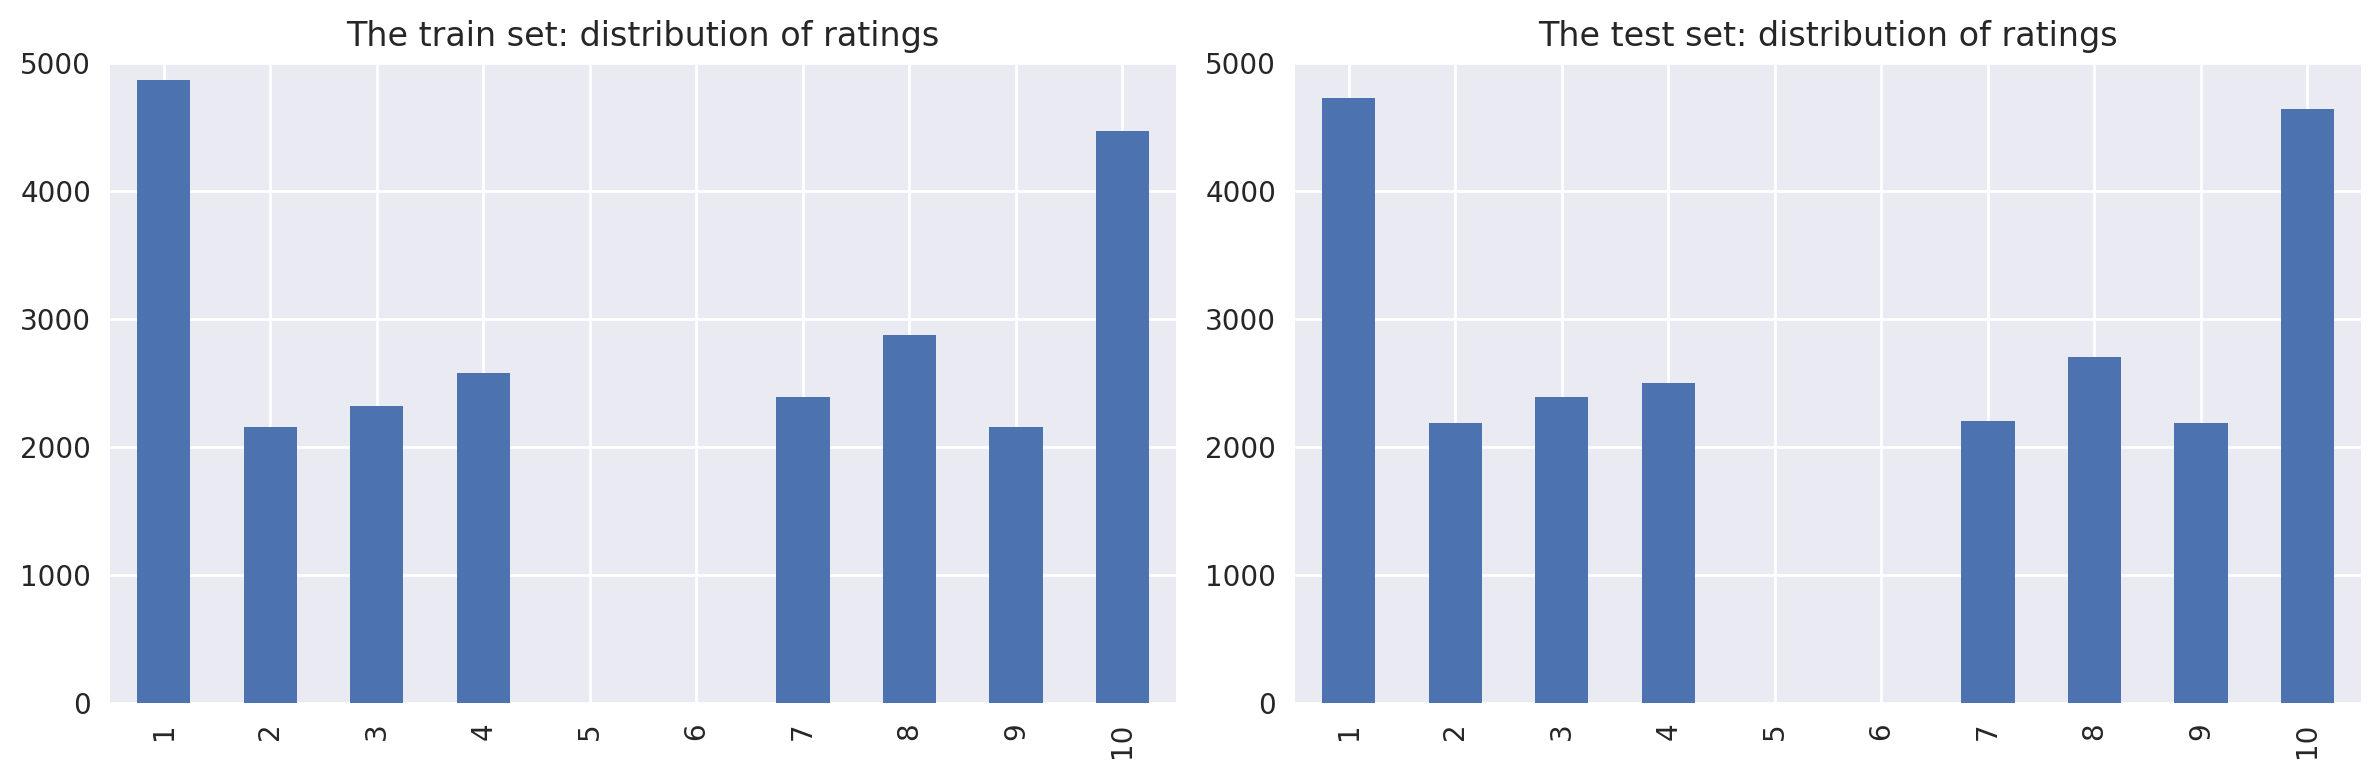

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

<span style= color:blue> Comments: Looking at the graphs above we observe a very identical distribution of 'ratings' for both the Test and Train datasets, this may not be the best case since it is more ideal to have a larger training dataset than a test dataset. The goal of a model is to use the training dataset to identify patterns and then check on the test dataset. Since the data here is pre-designed as such, I decided to leave it as it is here.

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


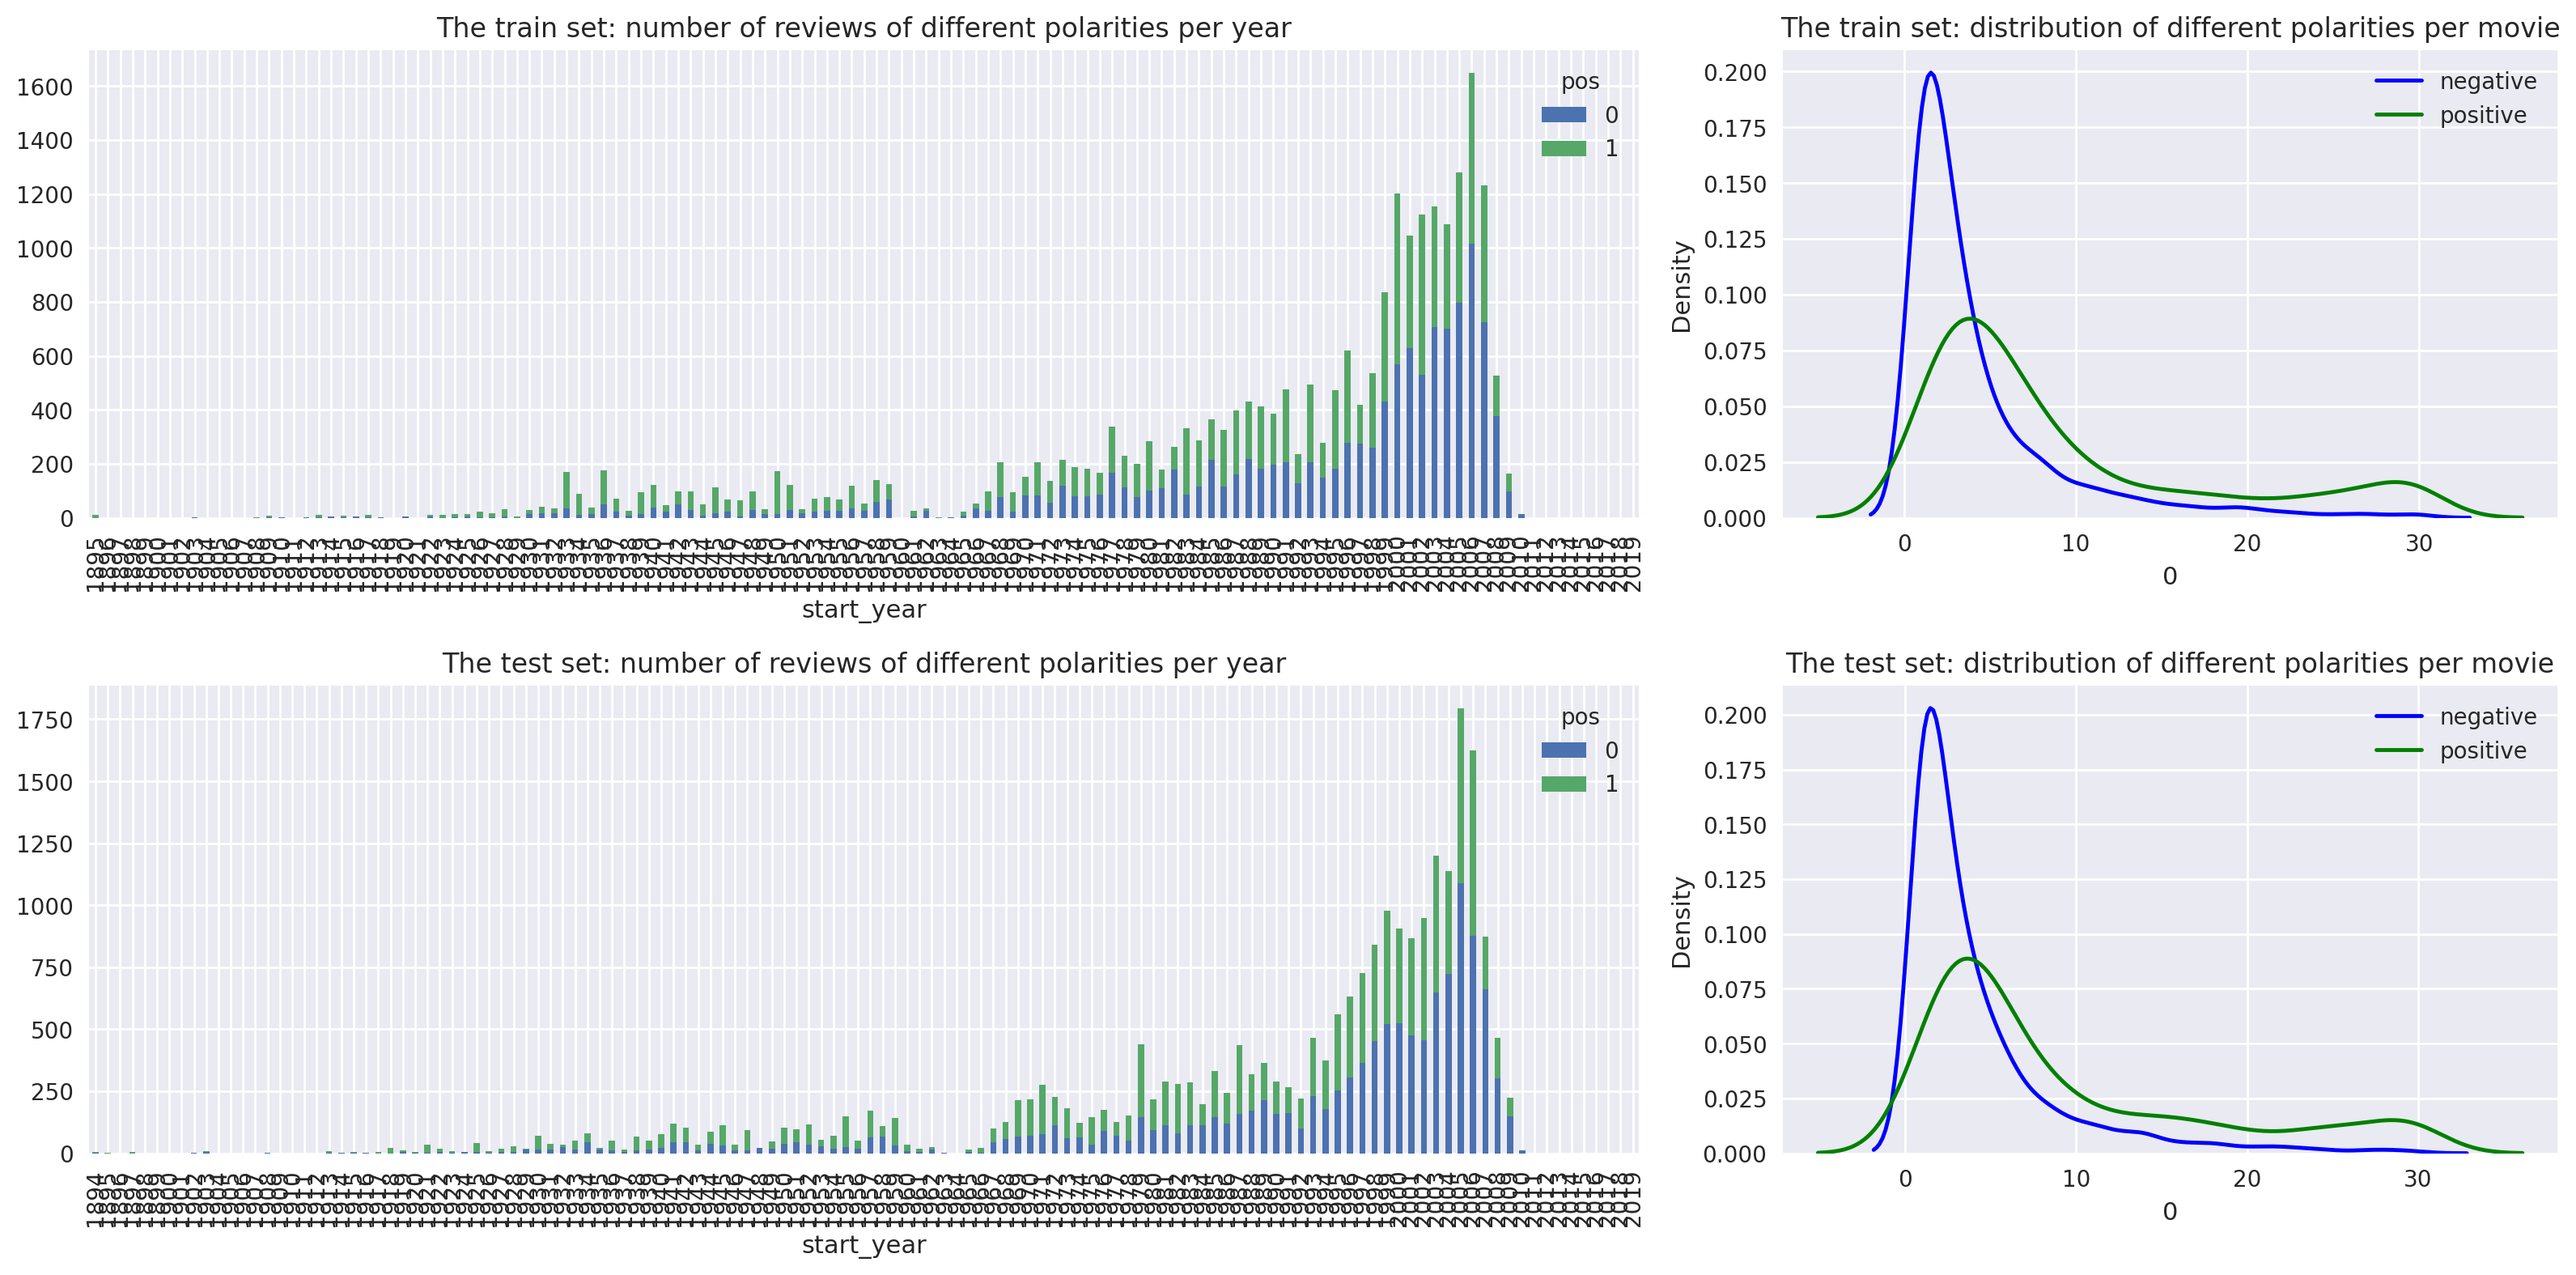

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<span style = color:blue> Comments: Looking at the graphs pre-coded above we can see the distributions of positive and negative reviews over the years for both Train and Test datasets. Using KDE plots we can conclude that both Test and Train datasets are in fact very similar in the data each contains regarding the density of both positive and negative reviews over the years. Moreover, we can tell the difference between the negative and positive reviews as well. We see that in both sets, there are high number of negative reviews. Once again KDE plots are useful in identifying differences between features and the values within a feature.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [18]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [19]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)# <put your code here>

<span style=color:blue> Comments: 
If we don't normalize the data, punctuation and digits can create useless tokens such as '12' or '!!', thus increasing dimensionality without adding value. As a result, it may reduce the model's generalization ability.



In [20]:
df_reviews.head(1)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...


<span style = color:blue>  Comments: For this Normalization section, the goal is to convert the review column into a new review_norm column that is clean. I wrote a function, since that is easiest to apply all those things in the least amount of code. The function normalize_text() takes in the input, in this case review column, and applies 4 different methods to convert to lowercase, remove digits, removes punctuations and finally removes any extra spaces.

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [21]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_feature = df_reviews_train['review_norm']
test_feature = df_reviews_test['review_norm']

print(df_reviews.shape)
print(df_reviews_train.shape)
print(df_reviews_test.shape)

(47329, 18)
(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [23]:
dummy_model = DummyClassifier(strategy = 'stratified', random_state = 123)
dummy_model.fit(train_feature, train_target)

y_pred_dummy = dummy_model.predict(test_feature)
f1_score_dummy = f1_score(test_target, y_pred_dummy)

print(f"Dummy Model F1 Score: {f1_score_dummy:.2f}")

Dummy Model F1 Score: 0.50


### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [24]:
import nltk
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [25]:
# Let's create a function to lemmatize the text
stop_words = set(stopwords.words('english'))
#nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

def lemma(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

In [26]:
# Now we can apply this lemmatize function onto the test and train features
train_feature_nltk = train_feature.apply(lemma)
test_feature_nltk = test_feature.apply(lemma)

# Then we can vectorize these features using TF-IDF
vectorizer_nltk = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_feature_tfidf_nltk = vectorizer_nltk.fit_transform(train_feature_nltk)
test_feature_tfidf_nltk = vectorizer_nltk.transform(test_feature_nltk)

In [27]:
# Train the LogisticRegression model
lr_model_nltk = LogisticRegression(max_iter = 1000, random_state = 123)
lr_model_nltk.fit(train_feature_tfidf_nltk, train_target)
y_pred_lr_nltk = lr_model_nltk.predict(test_feature_tfidf_nltk)
f1_score_lr_nltk = f1_score(test_target, y_pred_lr_nltk)

print(f"NLTK Logistic Regression F1 Score: {f1_score_lr_nltk:.2f}")

NLTK Logistic Regression F1 Score: 0.88


          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


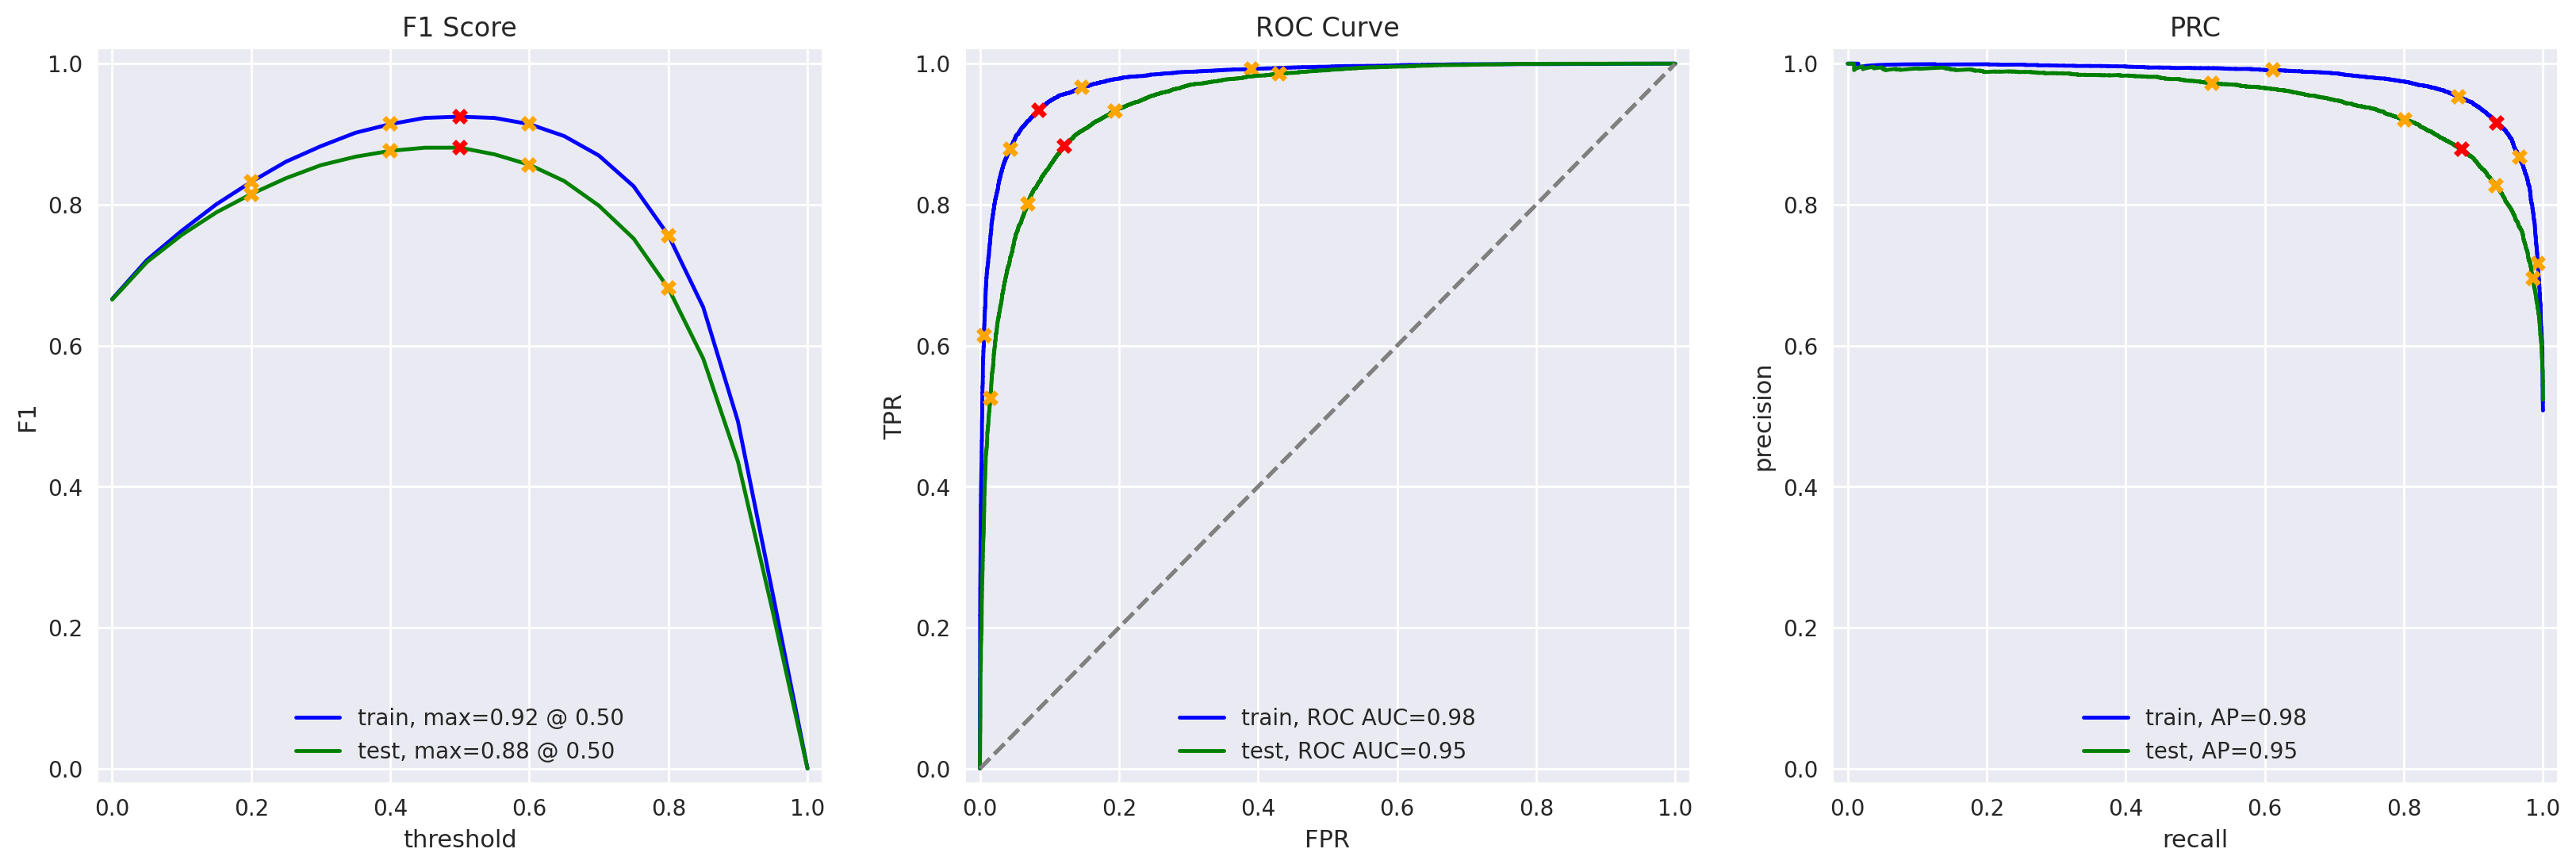

In [31]:
evaluate_model(lr_model_nltk, train_feature_tfidf_nltk, train_target, test_feature_tfidf_nltk, test_target)

<div span style=color:blue>  Comments: 
A dummy classifier does not learn patterns so it is a great way to establish a baseline. Using a dummy classifier, we get a F1 score of 0.50, this is extremely low given that the project requirement is 0.85. After this, we define a function to lemmatize the feature in order to reduce different forms of a word to its common base so that words like "eating" and "ate" become associated with "eat". This also reduces the number of words the model needs to be trained on. Next, we apply a form of vectorization, TF-IDF, to our feature column to let the model know that different words have different meaning, so certain words should hold more importance than others. For example, "great" should have a larger weight than "good".
All of this is called preprocessing and we use the toolkit NLTK to help us, since our feature column is movie reviews as long chains of text. Finally, we can train a LogisticRegression Model, predict on the test set and calculate the F1 Score. For this model we got a F1 Score of 0.88, which is much larger than the DummyClassifier and greater than the required 0.85 per the project requirements.
</div>

### Model 3 - spaCy, TF-IDF and LR

In [32]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
# Let's create a function for spaCy pre-processing
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
    return ' '.join(tokens)

In [34]:
# I built a new function because the pre-coded one was taking way too long
def spacy_preprocess_batch(texts, batch_size=100, n_process=2):

    processed_texts = []
    
    for doc in tqdm(nlp.pipe(texts, batch_size=batch_size, n_process=n_process), total=len(texts)):
        tokens = [token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-']
        processed_texts.append(' '.join(tokens))
    
    return processed_texts

In [35]:
train_feature_spacy = spacy_preprocess_batch(train_feature)
test_feature_spacy = spacy_preprocess_batch(test_feature)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23533 [00:00<?, ?it/s]

In [36]:
# Then we can vectorize these features using TF-IDF
vectorizer_spacy = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_feature_tfidf_spacy = vectorizer_spacy.fit_transform(train_feature_spacy)
test_feature_tfidf_spacy = vectorizer_spacy.transform(test_feature_spacy)

In [37]:
# Train the LogisticRegression model
lr_model_spacy = LogisticRegression(max_iter = 1000, random_state = 123)
lr_model_spacy.fit(train_feature_tfidf_spacy, train_target)
y_pred_lr_spacy = lr_model_spacy.predict(test_feature_tfidf_spacy)
f1_score_lr_spacy = f1_score(test_target, y_pred_lr_spacy)

print(f"spaCy Logistic Regression F1 Score: {f1_score_lr_spacy:.2f}")

spaCy Logistic Regression F1 Score: 0.87


          train  test
Accuracy   0.92  0.87
F1         0.92  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


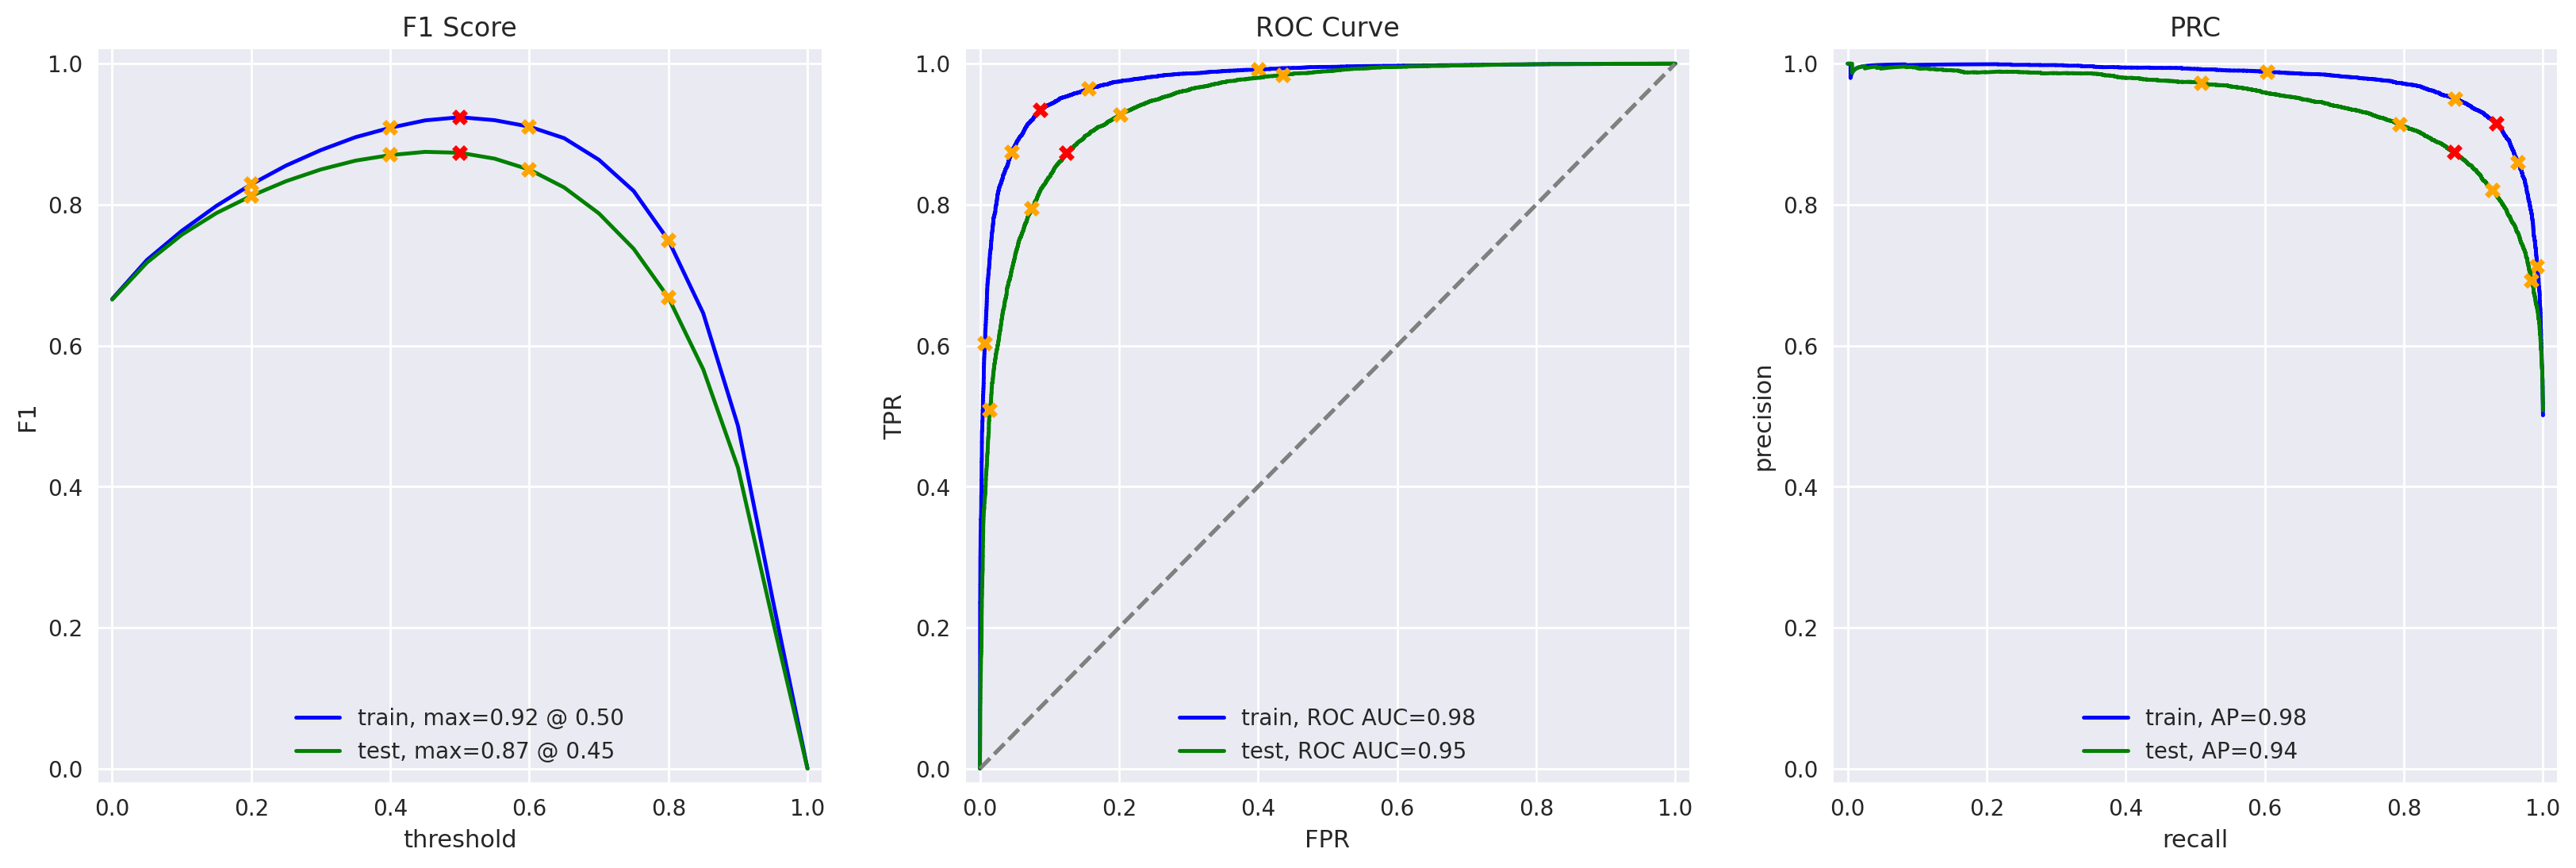

In [38]:
evaluate_model(lr_model_spacy, train_feature_tfidf_spacy, train_target, test_feature_tfidf_spacy, test_target)

<span style = color:blue> Comments: Next we built a new model again using Logistic Regression, however this time changing up the toolkit used for preprocessing from NLTK to spaCy. The precoded function for preprocessing, text_preprocessing_3(text), is actually very slow since spaCy processes one doc at a time. We have thousands of reviews as such this function did not even render on my computer. This led me to define a new function for preprocessing using nlp.pipe() in order to implement batch processing. I also wrapped my nlp.pipe in tqdm to show a progress bar; this is very useful when working with large datasets as it takes a long time to compute. A progress bar helps visualize the runtime. Once the preprocessing was complete, I used the same concept as earlier to vectorize my feature using TF-IDF and then train a Logistic Regression model as before. I calculated the F1_score for this model to be 0.87, once again higher than the required 0.85. This shows that there is not much difference between using NLTK and spaCy with our dataset.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [39]:
from lightgbm import LGBMClassifier

In [40]:
# Let's build a LGBM Classifier
model_lgbm = LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=15,random_state=123)

In [41]:
model_lgbm.fit(train_feature_tfidf_spacy, train_target)
y_pred_lgbm = model_lgbm.predict(test_feature_tfidf_spacy)
f1_score_lgbm = f1_score(test_target, y_pred_lgbm)

print(f"spaCy LGBM Classifier F1 Score: {f1_score_lgbm:.2f}")

spaCy LGBM Classifier F1 Score: 0.86


          train  test
Accuracy   0.96  0.86
F1         0.96  0.86
APS        0.99  0.94
ROC AUC    0.99  0.94


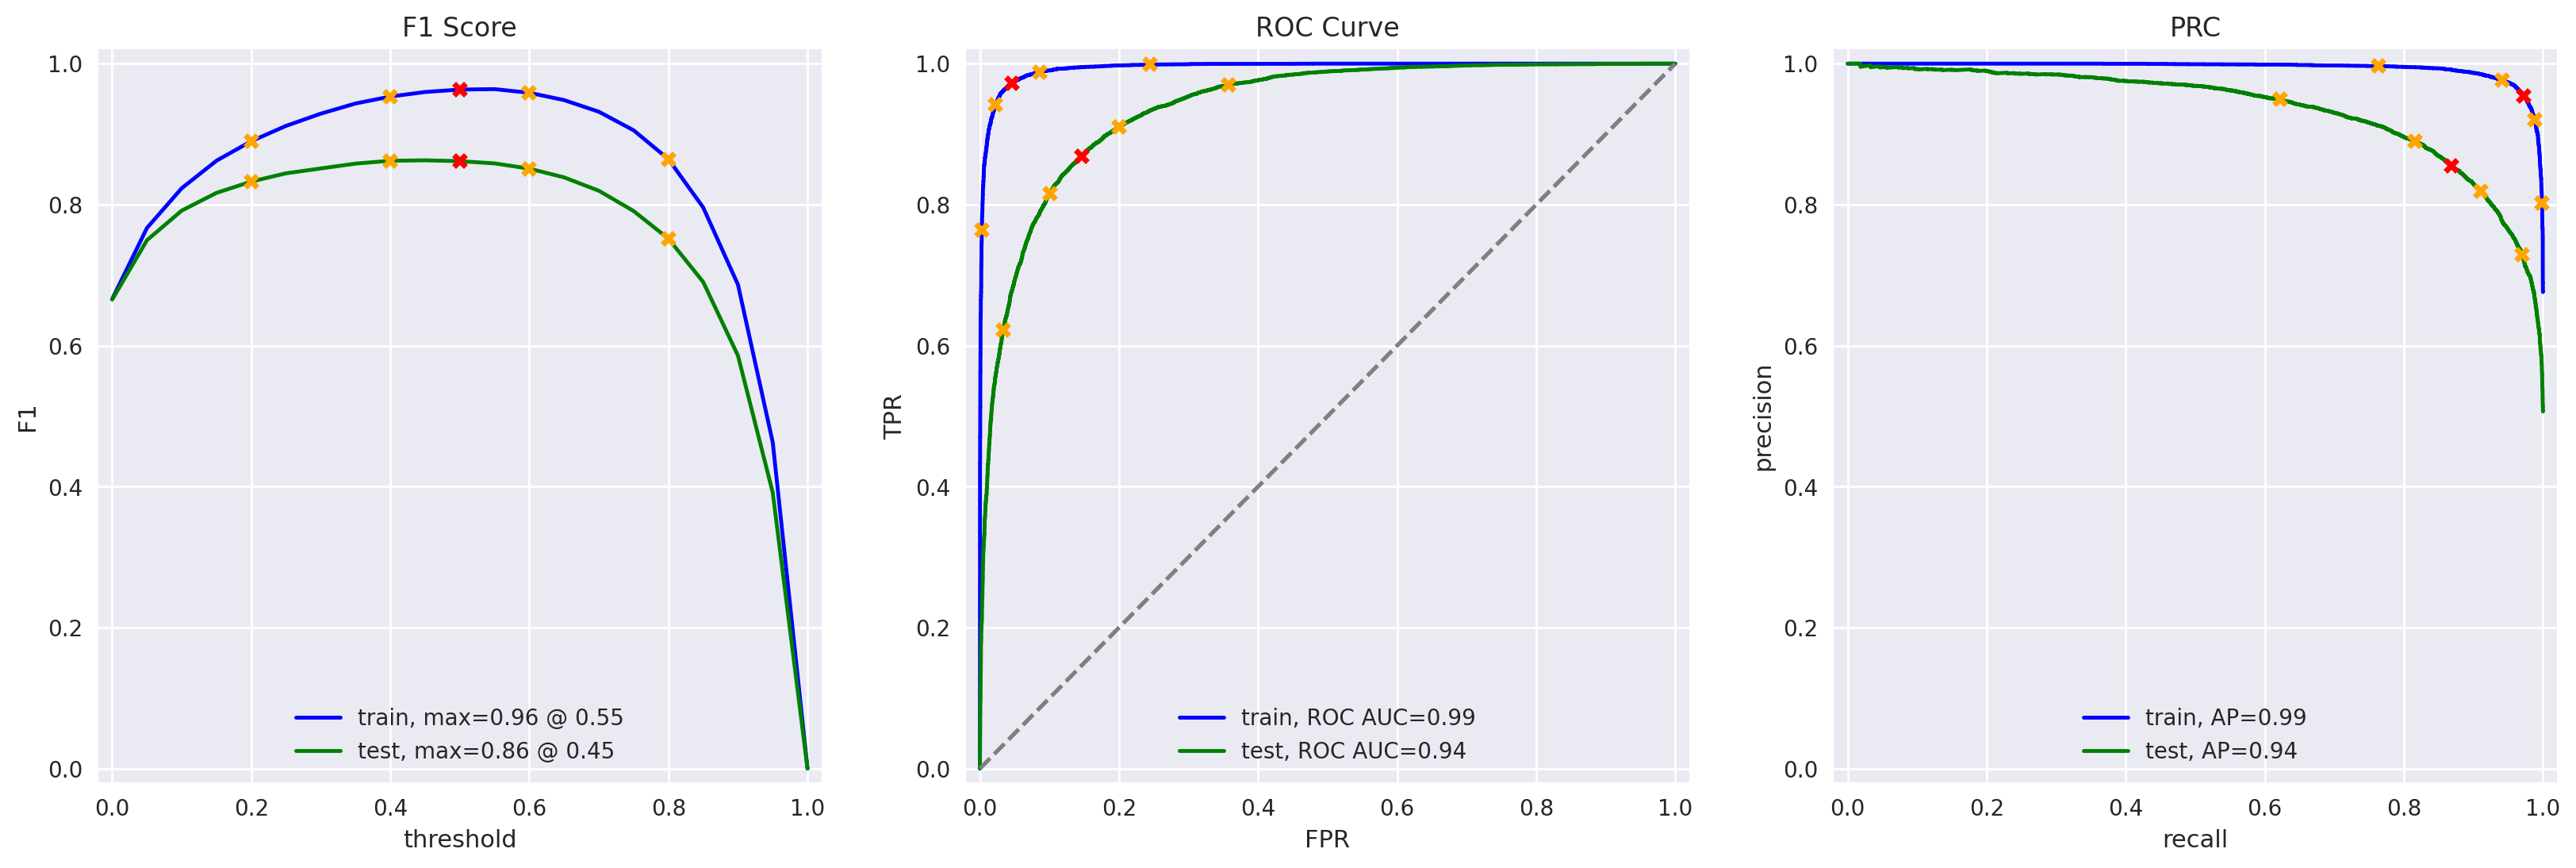

In [42]:
evaluate_model(model_lgbm, train_feature_tfidf_spacy, train_target, test_feature_tfidf_spacy, test_target)

<span style = color:blue>  Comments: Finaly I built one more model using Light GBM instead of Logistic Regression; however, we kept the preprocessing with spaCy and the vectorization with TF-IDF. Building this model on the same train_feature and predicting on the test_feature, we can hypertune the parameters to optimal condition and we get a F1_score of 0.86. This model and approach shows that LightGBM Classifier yields very similar F1 score value as Logistic Regression, meaning both models are good for usage in our case.

###  Model 9 - BERT

In [114]:
import torch
import transformers

In [121]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [116]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>

    for text in texts:
        encoding = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        ids_list.append(encoding['input_ids'][0])
        attention_mask_list.append(encoding['attention_mask'][0])
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []
    total_batches = math.ceil(len(ids_list)/batch_size)

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.stack(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
            embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [120]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

<span style=color:blue> Comments: I looked through and did some reasearch on BERT to understand how it works. However, I did not choose to finish the code and run it here since it was taking a long time. Using a small subset, we do get a faster runtime but since this was an optional part of the project, I will save working with BERT for later.

## My Reviews

In [43]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 2

In [51]:
texts = my_reviews['review_norm']
X_reviews_2 = vectorizer_nltk.transform(texts)
my_reviews_pred_prob = lr_model_nltk.predict_proba(X_reviews_2)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.60:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25:  i didnt expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<span style= color:blue> comments: using new reviews (pre-coded) we can try our trained models and understand what is happening. For the LR model using NLTK with the new reviews we can see it is doing a pretty good job! Take a look at the first 2 reviews, they are both negative as they include words like "not, bored, asleep". So the model gave them very low probabilities of being positive reviews. Likewise the 3rd review has the word "fascinated" so the model gave it a very high probability of being a positive review. However, this is not 100% accurate as we can see with review #5 that says they didn't expect the movie to be so good, but the model expects this to be a more negative review than a positive one. We can always expect some discrepencies but overall the LR model with NLTK worked pretty well for these reviews.

### Model 3

In [45]:
texts = my_reviews['review_norm']
texts_processed = spacy_preprocess_batch(my_reviews['review_norm'], batch_size=100, n_process=2)

X_reviews_3 = vectorizer_spacy.transform(texts_processed)
my_reviews_pred_prob = lr_model_spacy.predict_proba(X_reviews_3)[:, 1]
#my_reviews_pred_prob = lr_model_spacy.predict_proba(vectorizer_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]


for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

0.21:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.53:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.12:  i didnt expect the reboot to be so good writers really cared about the source material
0.45:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<span style = color:blue> Comments: Here we used the LR model with the spaCy toolkit and we get similar results to the NLTK model used above. We see the first 2 reviews have a greater probability for being negative whereas the 3rd and last have higher probabilities. The manner in which the model processes the words really matters because 3rd review says they were "really fascinated" which to most humans means a positive review but the model gives it about half and half chance. Furthermore, review #5 still poses the same problem because in a human mind that a positive review but the model is turning it into a negative review same as the previous model above.

### Model 4

In [50]:
texts = my_reviews['review_norm']
texts_processed = spacy_preprocess_batch(my_reviews['review_norm'], batch_size=100, n_process=2)

X_reviews_4 = X_reviews_3

my_reviews_pred_prob = model_lgbm.predict_proba(X_reviews_4)[:, 1]
#my_reviews_pred_prob = model_lgbm.predict_proba(vectorizer_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

  0%|          | 0/8 [00:00<?, ?it/s]

0.61:  i did not simply like it not my kind of movie
0.27:  well i was bored and felt asleep in the middle of the movie
0.64:  i was really fascinated with the movie
0.49:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.36:  i didnt expect the reboot to be so good writers really cared about the source material
0.61:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.17:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


<span style = color:blue> Comments: Interestingly LGBM Classifier model is not doing the best job here because it already get the first review incorrect, marking it a high probability to be positive when it is clearly a negative review. It still gets the 5th review wrong but it did give it a higher probability to be positive than the other 2 models. The rest of the reviews are accurate though. 

### Model 9

In [77]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

NameError: name 'BERT_text_to_embeddings' is not defined

## Conclusions

<div span style=color:blue> Conclusion:

This project was actually very good because it took Machine Learning to another level but a more relatable and everyday usage level with converting and understanding texts. We use texts for everything so it is critical to build a model that can intepret the meaning of our words and more so, we need models that can determine which words are more important than others. We started the project with an IMDB reviews database and that is great since it is very relatable and easily reproducible independently. A lot of the EDA was already precoded in the notebook so I did not have to do much there and that is fine since the goal of this project was to focus on the ML with text portion. I got a better idea of how to use preprocessing techniques like NLTK and spaCy and how each differs from the other. I also got to use LogisticRegression here since we've been using LinearRegression for the previous projects, so that was very cool to see. Then we compared the LR models with LightGBM which is quite fast but also very accurate. The metric to compare the models here was F1 score and all three models yielded a score of above 0.85. We used this to compare with the dummyclassifier which gave a baseline F1 score of 0.50. It is always good to have a baseline when working with Model building. Lastly we used some new data ("validation set") with precoded reviews and tested each of the 3 models to identify if the new reviews were more positive or more negative. The models used probabilties this time to give a range of the positivity of a review. Each model behaved well but also had some mistakes and room for improvements. Nevertheless, it was a great project to teach us of how to use ML models when working with human language rather than numbers. This time we only worked with English but I am eager to try this onto different languages as well.

Note: I did not work with BERT as much here but I look forward to using it and learning more about it in the future.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions